In [20]:
import os
from typing import List

import numpy as np
import pandas as pd
from comet_ml import Experiment
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# !pip install pydot
import pydot
import tensorflow_hub as hub

In [21]:
train_df = pd.read_csv('../data/tweets_50_shuffled_train.csv')
test_df = pd.read_csv('../data/tweets_50_shuffled_test.csv')
X_train = train_df['text_tokenized']
y_train = train_df['label']
X_test = test_df['text_tokenized']
y_test = test_df['label']

class_names = y_train.unique()

In [22]:
batch_size = 128
max_tokens = 30_000
output_sequence_length= 400
embedding_dim = 300



def make_vectorizer(max_tokens: int, output_sequence_length: int) -> TextVectorization:
    vect = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length)
    text_ds = tf.data.Dataset.from_tensor_slices(X_train.values).batch(batch_size)
    vect.adapt(text_ds)
    return vect


def get_embedding_matrix(embedding_dim, num_tokens, word_index):
    path_to_glove_file = os.path.join(
        os.path.expanduser("~"), f"Documents/Datasets/glove.6B.{embedding_dim}d.txt"
    )
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print("Found {} word vectors.".format(len(embeddings_index)))
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


def make_embedding_layer(voc: List[str], embedding_dim: int) -> layers.Embedding:
    word_index = dict(zip(voc, range(len(voc))))
    num_tokens = len(voc) + 2

    # just testing if word_index works
    test = ["the", "cat", "sat", "on", "the", "mat"]
    print("word_index test:")
    print(test, " --> ", [word_index[w] for w in test])

    embedding_matrix = get_embedding_matrix(embedding_dim, num_tokens, word_index)

    return layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )


vectorizer = make_vectorizer(max_tokens=max_tokens,
                             output_sequence_length=output_sequence_length)
vocabulary = vectorizer.get_vocabulary()
embedding_layer = make_embedding_layer(vocabulary, embedding_dim=embedding_dim)


word_index test:
['the', 'cat', 'sat', 'on', 'the', 'mat']  -->  [4, 945, 2154, 19, 4, 7209]
Found 400000 word vectors.
Converted 26102 words (3898 misses)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_6 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 48,197,515
Trainable params: 6,915
Non-trainable params: 48,190,600
_________________________________________________________________


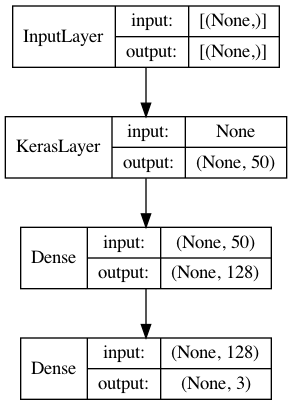

In [23]:
batch_size = 128
embed_model="https://tfhub.dev/google/nnlm-en-dim50/2"
embedding_dim = 128
activation = 'relu'
kernel_initializer = 'he_normal'
l2_lambda = 1e-3
dropout=0.5
filters = 64
kernel_sizes = [1, 2, 3]
n_convs_parallel = len(kernel_sizes)
padding='same'
pool_size = 2
strides = 1
epochs = 200
optimizer = 'nadam'

def make_model():
    regularizers = keras.regularizers.l2(l2=l2_lambda)
    model = keras.Sequential([
        hub.KerasLayer(embed_model, dtype=tf.string, input_shape=[],),
        keras.layers.Dense(128, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers),
        keras.layers.Dense(len(class_names), activation="softmax")
    ])
    model.summary()

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
    )
    return model
# model.compile(
#     loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
# )
#     return model
model = make_model()
keras.utils.plot_model(model, "model-embeddings.png", show_shapes=True,show_layer_names=False)


In [24]:
# model = make_model()
# keras.utils.plot_model(model, "model-rnn.png", show_shapes=True)
# experiment.log_asset("model-rnn.png")

# project_name = 'nlp_embeddings_rnn'
# experiment = Experiment(
#     project_name=project_name,
#     auto_param_logging=True,
#     # auto_histogram_weight_logging=True,
#     auto_histogram_gradient_logging=True,
#     auto_histogram_activation_logging=True,
#     api_key="HeH9EtfDC2KUlCOjeQaU1CuOM",
#     workspace="henrystoll",
#     disabled=False,
# )
# params = {
#     'batch_size': batch_size,
#     'max_tokens': max_tokens,
#     'output_sequence_length': output_sequence_length,
#     'embedding_dim': embedding_dim,
#     'units': units,
#     'rnn': rnn,
#     # 'activation': activation,
#     # 'kernel_initializer': kernel_initializer,
#     # 'l2_lambda': l2_lambda,
#     'dropout': dropout,
#     'recurrent_dropout': recurrent_dropout,
#     'class_weight': class_weight,
#     'optimizer': optimizer,
#     'epochs': epochs,
# }

# experiment.log_parameters(params)

# model = make_model()
# keras.utils.plot_model(model, "model-rnn.png", show_shapes=True)
# experiment.log_asset("model-rnn.png")

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_acc',
#     patience=10,
#     verbose=1,
#     restore_best_weights=True)

# with experiment.train():
#     history = model.fit(X_train, y_train,
#                         batch_size=batch_size,
#                         epochs=epochs,
#                         validation_data=(X_val, y_val),
#                         # class_weight=class_weight,
#                         verbose=1,
#                         callbacks=[early_stopping])

# with experiment.test():
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(loss, accuracy)
#     metrics = {
#         'loss': loss,
#         'accuracy': accuracy
#     }
#     experiment.log_metrics(metrics)

# y_predicted = model.predict(X_test)
# y_predicted = y_predicted.argmax(axis=1)
# experiment.log_confusion_matrix(y_test.to_numpy(), y_predicted)

# experiment.end()